In [4]:
# %%
from SonicBatt import utils
import os
import json
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.models import load_model

root_dir = utils.root_dir()
study_path = os.path.join(root_dir, 'studies', 'multi-cell_ml')
data_path = os.path.join(study_path, 'Raw Data')
visualistion_path = os.path.join(study_path, 'Visualisation')
ancillary_data_path = os.path.join(study_path, 'Ancillary Data')
models_path = os.path.join(study_path, 'Models', 'Classification')

database = pd.read_excel(os.path.join(data_path, 'database.xlsx'))
df_cell_aliases =  pd.read_excel(os.path.join(data_path, 'database.xlsx'),
                              sheet_name='cell_aliases')
cell_aliases = {}
for _, row in df_cell_aliases.iterrows():
    cell_aliases[row['cell_id']] = row['cell_alias']

parquet_filename = 'signals_peaks_fft.parquet'
parquet_filepath = os.path.join(ancillary_data_path, parquet_filename)
df = pd.read_parquet(parquet_filepath)
# Get rid of the invariable parts of the acoustic signals
df = df.drop(columns = [('acoustics', str(i)) for i in range(758)])

label_column = ('cycling', 'Cell_ID')
# Replace cell_ids with the cell aliases
df[label_column] = df[label_column].replace(cell_aliases)
y = df.loc[:, label_column].to_numpy()
# Labels must start at zero!
y -= 1
# I am using the SparseCategoricalCrossEntropy function which expects labels to be ingeger
# values. If it is desirable to use one-hot encoded abels, use the CategoricalCrossEntropy instead.

with open(os.path.join(ancillary_data_path,'cells_together_split.json'), 'r') as fp:
    cells_together_split = json.load(fp)
with open(os.path.join(ancillary_data_path,'cells_separated_splits.json'), 'r') as fp:
    cells_separated_splits = json.load(fp)

model_params = pd.read_excel(
    os.path.join(models_path, 'Model_parameters_classification.xlsx'), index_col=0)


In [5]:
# %%
representations = [
    'ffnn_1x2_sch2',
    'ffnn_1x5_sch2',
    'ffnn_1x10_sch2',
    'ffnn_2x2_sch2',
    'ffnn_2x5_sch2',
    'ffnn_2x10_sch2',
]

data_configs = {
    'A': [('peak_tofs', '8'), ('peak_heights', '8')],
    'B': ['peak_tofs'],
    'C': ['peak_tofs', 'peak_heights'],
    'D': ['acoustics'],
}

def config_data(data_config, Fold = None):
    if Fold == None:
        train_indices = cells_together_split['train']
        val_indices = cells_together_split['val']
        test_indices = cells_together_split['test']
    else:
        train_indices = cells_separated_splits[Fold]['train']
        val_indices = cells_separated_splits[Fold]['val']
        test_indices = cells_separated_splits[Fold]['test']        
    #
    if data_config != 'G':
        feature_columns = data_configs[data_config]
        X_train = df.loc[train_indices, feature_columns].to_numpy()
        X_val = df.loc[val_indices, feature_columns].to_numpy()
        X_test = df.loc[test_indices, feature_columns].to_numpy()
    # else:
    #     X_train = spectrograms[train_indices]
    #     X_val = spectrograms[val_indices]
    #     X_test = spectrograms[test_indices]
    #
    y_train = df.loc[train_indices, label_column].to_numpy().reshape(-1,1)
    y_val = df.loc[val_indices, label_column].to_numpy().reshape(-1,1)
    y_test = df.loc[test_indices, label_column].to_numpy().reshape(-1,1)
    #
    return (X_train, y_train, X_val, y_val, X_test, y_test)


In [6]:
# %%
accuracy = pd.DataFrame(
        index = representations, columns = data_configs.keys())
for data_config in data_configs.keys():
    X_train, y_train, X_val, y_val, X_test, y_test = config_data(data_config)
    for representation in representations:
        model_name = '{}_{}'.format(representation, data_config)
        save_dir_model = os.path.join(models_path, model_name)
        model = load_model(os.path.join(save_dir_model, model_name + '.h5'))
        probability_model = tf.keras.Sequential([model, 
                                         tf.keras.layers.Softmax()])
        y_pred_test = np.argmax(probability_model.predict(X_test), axis=1)
        accuracy_value = np.sum(y_test.ravel() == y_pred_test) / len(y_test)
        
        accuracy.loc[representation, data_config] = accuracy_value


419/419 [==============================] - 0s 1ms/step


In [7]:
# %%
markers = {
    'A': 'd',
    'B': 'P',
    'C': '<',
    'D': 'v',
    'E': 'o',
    'F': 's',
    'G': 'X'
}

cols = {
    'A': 'tab:purple',
    'B': 'tab:cyan',
    'C': 'tab:red',
    'D': 'tab:green',
    'E': 'tab:blue',
    'F': 'tab:orange',
    'G': 'k'
}


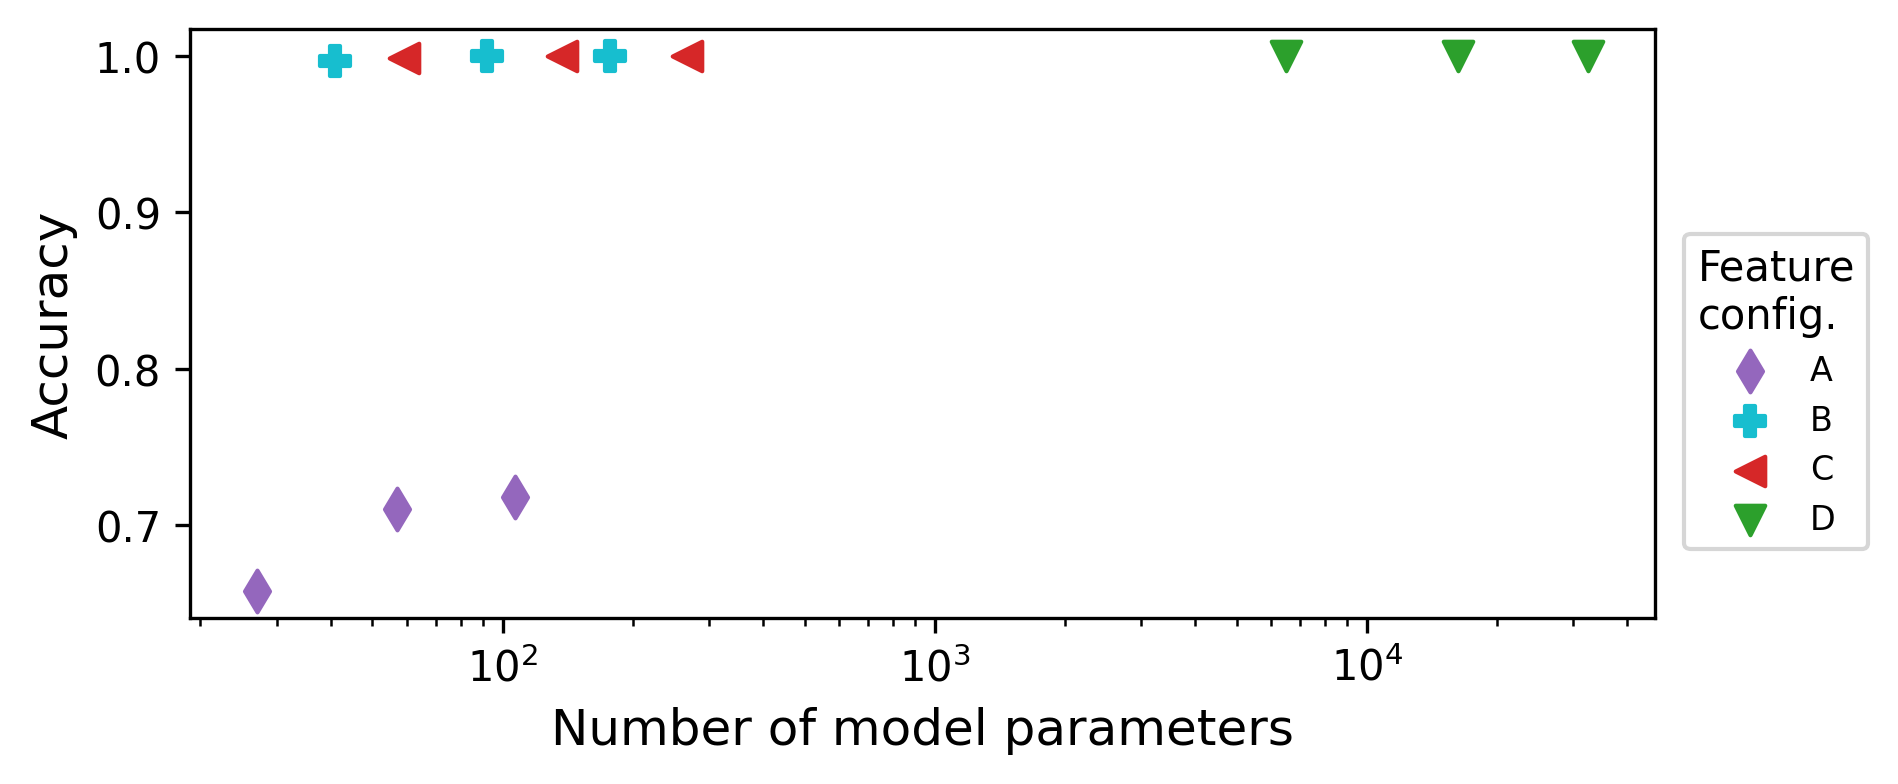

In [13]:
# %%
mpl.rc('xtick', labelsize=10)
mpl.rc('ytick', labelsize=10)
mpl.rc('legend', fontsize=8, title_fontsize=10)
mpl.rc('font', size=12)

s=50
f, axs = plt.subplots(1,1,figsize=(5.5,2.5), constrained_layout=True, dpi=300)
f.patch.set_facecolor('white')
for data_config in data_configs.keys():
    for i, representation in enumerate(
        ['ffnn_1x2_sch2', 'ffnn_1x5_sch2', 'ffnn_1x10_sch2']):# enumerate(representations):
        repr_short = representation[:-5]
        n_params = model_params.loc[repr_short, data_config]
        accuracy_test = accuracy.loc[representation, data_config]

        if i == 0:
            label = data_config
        else:
            label = None
        if '_2x' in representation:
            facecolors='none'
            hatch =  None # None | '///////'
        elif '_3x' in representation:
            facecolors='none'
            hatch = '||||||||'
        else:
            facecolors=cols[data_config]
            hatch = None
        axs.scatter(n_params, accuracy_test, label=label, marker=markers[data_config],
                    facecolors=facecolors, edgecolors=cols[data_config],
                    hatch=hatch, s=s)
 
axs.set_xlabel('Number of model parameters')
axs.set_ylabel('Accuracy', horizontalalignment='center')
axs.set_xscale('log')
f.legend(loc='center left', bbox_to_anchor=(1, 0.5), title = 'Feature\nconfig.')

save_filename = 'Classification'
utils.save_figure(f, visualistion_path, save_filename, format='pdf')
utils.save_figure(f, visualistion_path, save_filename, format='png')

mpl.rcdefaults()


419/419 [==============================] - 1s 2ms/step


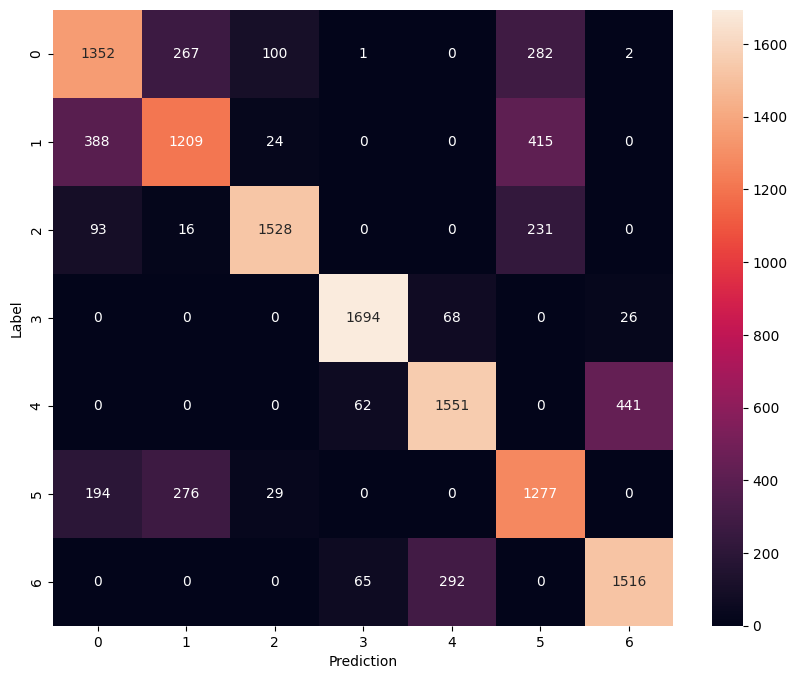

In [6]:
# %%
data_config = 'A'
X_train, y_train, X_val, y_val, X_test, y_test = config_data(data_config)

representation = 'ffnn_2x10_sch2'
model_name = '{}_{}'.format(representation, data_config)
save_dir_model = os.path.join(models_path, model_name)
model = load_model(os.path.join(save_dir_model, model_name + '.h5'))

# y_pred_train = model.predict(X_train)
# y_pred_val = model.predict(X_val)
# y_pred_test = model.predict(X_test)

probability_model = tf.keras.Sequential([model, 
                                         tf.keras.layers.Softmax()])
y_pred_train = np.argmax(probability_model.predict(X_train), axis=1)
y_pred_val = np.argmax(probability_model.predict(X_val), axis=1)
y_pred_test = np.argmax(probability_model.predict(X_test), axis=1)

import seaborn as sns
confusion_mtx = tf.math.confusion_matrix(y_test, y_pred_test)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=[0, 1, 2, 3, 4, 5, 6],
            yticklabels=[0, 1, 2, 3, 4, 5, 6],
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()
accuracy = np.sum(y_test.ravel() == y_pred_test) / len(y_test)